Implement:

1. Naive Forecast

2. Seasonal Naive Forecast

3. Prophet model

Evaluate all models using proper metrics

In [10]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.metrics import mean_squared_error as mse, root_mean_squared_error as rmse, mean_absolute_error as mae
from prophet import Prophet

plt.style.use("seaborn-v0_8-darkgrid")

In [6]:
train_df = pd.read_csv("../results/Delhi_Hourly_train.csv", parse_dates=["ds"])
test_df = pd.read_csv("../results/Delhi_Hourly_test.csv", parse_dates=["ds"])

train_df, test_df

(                       ds            y  temp   dwpt   rhum   wdir  wspd  \
 0     2021-01-08 00:00:00  4697.857500  13.0  11.60   91.0  145.0   2.7   
 1     2021-01-08 01:00:00  4430.386667  13.0  12.10   94.0    0.0   0.0   
 2     2021-01-08 02:00:00  4238.806667  12.6  12.15   97.0    0.0   0.0   
 3     2021-01-08 03:00:00  4055.965833  12.1  12.10  100.0    0.0   0.0   
 4     2021-01-08 04:00:00  3894.686667  12.0  12.00  100.0    0.0   0.0   
 ...                   ...          ...   ...    ...    ...    ...   ...   
 27528 2024-02-29 00:00:00  2081.147500  18.0  10.35   61.0  290.0   7.6   
 27529 2024-02-29 01:00:00  1917.576667  17.5  10.00   61.5  280.0   6.5   
 27530 2024-02-29 02:00:00  1826.179167  16.0  10.45   70.0  255.0   6.2   
 27531 2024-02-29 03:00:00  1791.240833  14.5  11.00   79.5  250.0   7.3   
 27532 2024-02-29 04:00:00  1874.160833  14.0  11.00   82.0  255.0   7.6   
 
           pres  hour  weekday  month  is_weekend  hour_sin  hour_cos  \
 0      1014.

In [9]:
# Quick Sanity Check (Train comes before test and no overlapping.)
print("Train Range:", train_df.ds.min(), "->", train_df.ds.max())
print("Test Range:", test_df.ds.min(), "->", test_df.ds.max())

Train Range: 2021-01-08 00:00:00 -> 2024-02-29 04:00:00
Test Range: 2024-02-29 05:00:00 -> 2024-12-12 00:00:00


METRICS USED :
1. MAE : Easy to interpret
2. RMSE : Penalizes large errors

In [11]:
def evaluate(y_true, y_pred):
    MAE =  mae(y_true, y_pred)
    RMSE = rmse(y_true, y_pred)
    return MAE, RMSE

BASELINE 1 - NAIVE FORECAST

In [13]:
# Implement Naive
last_train_value = train_df["y"].iloc[-1]
naive_forecast = np.full(shape=len(test_df), fill_value=last_train_value)

In [18]:
# Evaluate Naive
naive_mae, naive_rmse = evaluate(test_df["y"], naive_forecast)
print(f"Naive Forcast => MAE:{naive_mae:.2f}, RMSE:{naive_rmse:.2f}")

Naive Forcast => MAE:2723.24, RMSE:3054.62


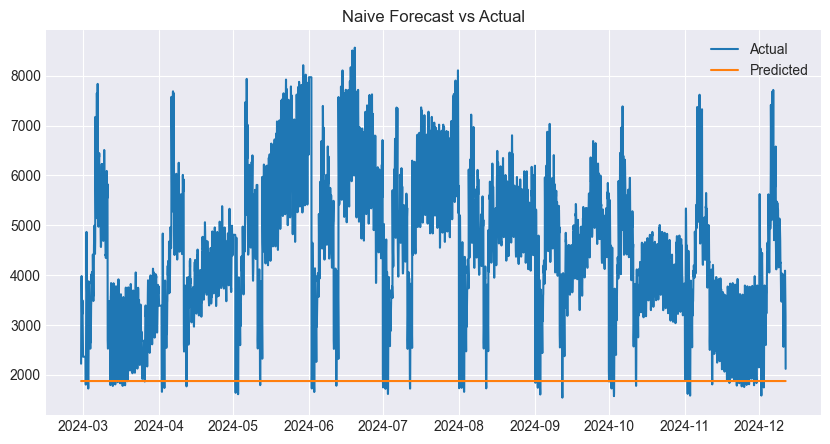

In [19]:
# Plot Naive
plt.figure(figsize=(10, 5))
plt.plot(test_df.ds, test_df.y, label="Actual")
plt.plot(test_df.ds, naive_forecast, label="Predicted")
plt.title("Naive Forecast vs Actual")
plt.legend()
plt.show()

BASELINE 2 - SEASONAL NAIVE FORECAST

In [37]:
# Implement Seasonal Naive
seasonal_lag = 24
seasonal_naive_forecast = test_df["lag_24"].values

In [38]:
# Evaluate Seasonal Naive
seasonal_mae, seasonal_rmse = evaluate(test_df["y"], seasonal_naive_forecast)
print(f"Seasonal Naive → MAE: {seasonal_mae:.2f}, RMSE: {seasonal_rmse:.2f}")

Seasonal Naive → MAE: 560.21, RMSE: 876.42


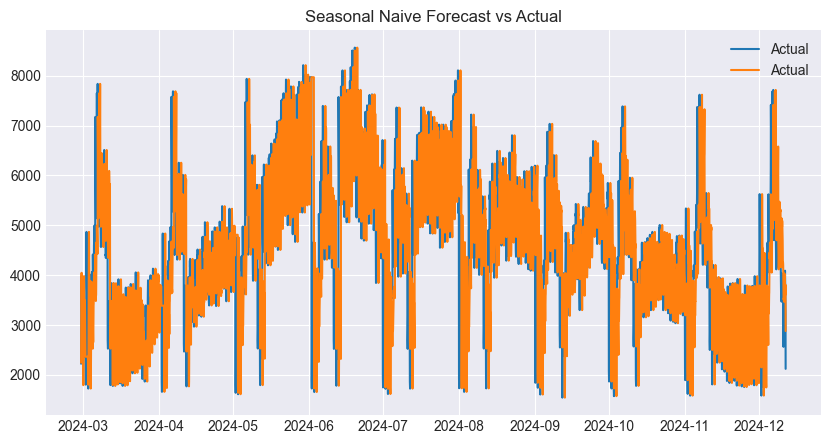

In [39]:
# Plot Seasonal Naive
plt.figure(figsize=(10, 5))
plt.plot(test_df.ds, test_df.y, label="Actual")
plt.plot(test_df.ds, seasonal_naive_forecast, label="Actual")
plt.title("Seasonal Naive Forecast vs Actual")
plt.legend()
plt.show()

BASELINE 3 - PROPHET

In [40]:
prophet_train = train_df[["ds", "y"]].copy()
prophet_test = test_df[["ds", "y"]].copy()

In [41]:
prophet_model = Prophet(
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=False
)
prophet_model.fit(prophet_train)

00:32:10 - cmdstanpy - INFO - Chain [1] start processing
00:32:21 - cmdstanpy - INFO - Chain [1] done processing


In [42]:
future = prophet_model.make_future_dataframe(
    periods=len(test_df),
    freq="h"
)
forecast = prophet_model.predict(future)
prophet_pred = forecast["yhat"].iloc[-len(test_df):].values

In [43]:
# Evaluate Prophet
prophet_mae, prophet_rmse = evaluate(test_df["y"], prophet_pred)
print(f"Prophet → MAE: {prophet_mae:.2f}, RMSE: {prophet_rmse:.2f}")

Prophet → MAE: 2527.92, RMSE: 2870.06


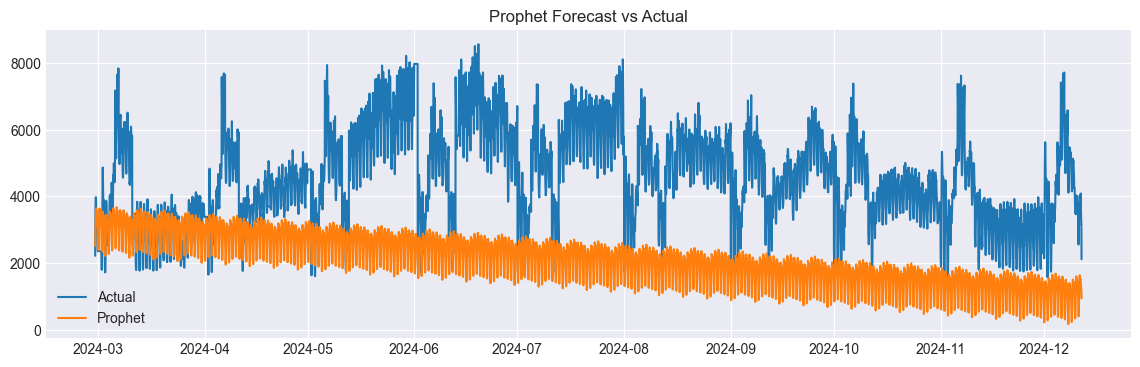

In [45]:
# Plot Prophet Model
plt.figure(figsize=(14,4))
plt.plot(test_df.ds, test_df.y, label="Actual")
plt.plot(test_df.ds, prophet_pred, label="Prophet")
plt.title("Prophet Forecast vs Actual")
plt.legend()
plt.show()

In [46]:
# Final Comparison

baseline_results = pd.DataFrame({
    "Model": ["Naive", "Seasonal Naive", "Prophet"],
    "MAE":   [naive_mae, seasonal_mae, prophet_mae],
    "RMSE":  [naive_rmse, seasonal_rmse, prophet_rmse]
})

baseline_results

,Model,MAE,RMSE
0,Naive,2723.244820,3054.616758
1,Seasonal Naive,560.206025,876.422789
2,Prophet,2527.916802,2870.063555


Prophet underperformed compared to a simple seasonal naive baseline, indicating that electricity demand dynamics are dominated by short-term seasonal repetition rather than smooth trend components.